In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import tqdm
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
# нормализация
def normalize(X,Y):
    mean = np.mean(Y, axis=0)
    std = np.std(Y, axis=0) + 0.01
    return (X - mean) / std

In [3]:
# класс one-hot encoder'а для MNIST
class OneHotEncoder:
    def __init__(self):
        self.transform_mapping = np.zeros((10,10))
        for i in range(self.transform_mapping.shape[0]):
            self.transform_mapping[i][i] = 1.0
    def transform(self, y):
        return self.transform_mapping[int(y)]

In [4]:
def make_submission(X_test, net, iter, fname="my_submission.csv"):
    net.set_train(False)
    fname = str(iter) + "_" + fname
    with open(fname,'w') as fout:
        fout.write('Id,Category')
        for i in range(X_test.shape[0]):
            y_h = net.forward(X_test[i])
            y = np.argmax(y_h)
            fout.write("\n{},{}".format(i, int(y)))

In [5]:
# внимание, тут Y_test в обычном формате(не onehot)
def compute_acc(X_test, Y_test, net):
    acc = 0.0
    for i in range(X_test.shape[0]):
        y_h = net.forward(X_test[i])
        y = np.argmax(y_h)
        if(y == Y_test[i]):
            acc += 1.0
    return acc / Y_test.shape[0]

In [6]:
train_data = None
test_data = None
encoder = OneHotEncoder()

with open('data_train.pickle','rb') as fin:
    train_data = pickle.load(fin)
with open('data_test_no_labels.pickle','rb') as fin:
    test_data = pickle.load(fin)
    
# трейнинговые сеты    
X_train = train_data['data']
Y_train = train_data['target']

# тестовый сет
X_test_set = test_data['data']

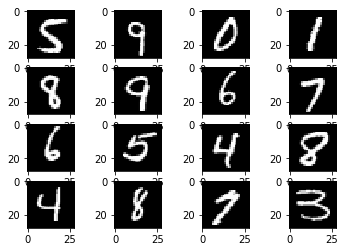

In [7]:
n=4
for i in range(n*n):
    plt.subplot(n,n,i+1)
    I = train_data['data'][np.random.randint(0, X_train.shape[0]),:]
    I = I.reshape((28, 28))
    plt.imshow(I, cmap='gray')

In [8]:
# подготовка датасета
X_train = normalize(X_train,X_train)
X_test_set_t = normalize(X_test_set, X_test_set)
X_test_set = normalize(X_test_set, X_train)

# разделение данных на тренинговые и валидационные сеты
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=10)

# кодирование
Y_train_enc = np.array(list(map(lambda x : encoder.transform(x), Y_train)))
Y_test_enc = np.array(list(map(lambda x : encoder.transform(x), Y_test)))

In [9]:
# Определение слоев сети
class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
    
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
   
    def backward(self, dz, lr=0.001):
        # градиенты по параметрам
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # производная по входу
        self.dx = np.matmul(dz, self.W) 

        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
            
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        
        return self.dx

class Dropout:
    def __init__(self, p = 0.5):
        self.p = p
        self.train = True
    
    def set_train(self, train = True):
        self.train = train
    
    def forward(self, x):
        if not self.train: # если не в стадии обучения, то не применяем Dropout
            self.mask = np.ones(*x.shape)
            return x
        self.mask = ( np.random.rand(*x.shape) > self.p ) / (1.0 - self.p)
        return x * self.mask
    # нейроны, которые занулены, не обучаются    
    def backward(self, dz, lr=0.001):
        return dz * self.mask    
    
# Функция активации ReLu
class Max:
    
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.001):
        dz[self.x < 0] = 0
        return dz

# Функция активации SoftMax
class Softmax:
    
    def forward(self, x):
        self.x = x
        exps = np.exp(x)
        return exps / np.sum(exps)
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)
    
# Функция ошибки
class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat) )
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

In [10]:
# Определение самой сети
class MnistNet:
    
    def __init__(self, rlambda=0.0): # rlambda - параметр регуляризации
        self.dr1 = Dropout(0.4)
        self.d1 = Dense(784, 392, rlambda)
        self.m1 = Max()
        self.dr2 = Dropout(0.35)
        self.d2 = Dense(392, 192, rlambda)
        self.m2 = Max()
        self.dr3 = Dropout(0.3)
        self.d3 = Dense(192, 98, rlambda)
        self.m4 = Max()
        self.dr4 = Dropout(0.25)
        self.d4 = Dense(98, 28, rlambda)
        self.m3 = Max()
        self.d5 = Dense(28, 10, rlambda)
        self.s = Softmax()
    
    def forward(self, x):
        net = self.dr1.forward(x)
        net = self.d1.forward(net)
        net = self.m1.forward(net)
        net = self.dr2.forward(net)
        net = self.d2.forward(net)
        net = self.m2.forward(net)
        net = self.dr3.forward(net)
        net = self.d3.forward(net)
        net = self.m3.forward(net)
        net = self.dr4.forward(net)
        net = self.d4.forward(net)
        net = self.m4.forward(net)
        net = self.d5.forward(net)
        net = self.s.forward(net)
        return net
    
    def backward(self, dz, lr):
        dz = self.s.backward(dz, lr)
        dz = self.d5.backward(dz, lr)
        dz = self.m4.backward(dz, lr)
        dz = self.d4.backward(dz, lr)
        dz = self.dr4.backward(dz, lr)
        dz = self.m3.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        dz = self.dr3.backward(dz, lr)
        dz = self.m2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        dz = self.dr2.backward(dz, lr)
        dz = self.m1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        dz = self.dr1.backward(dz, lr)
        return dz
    def set_train(self, train=True):
        self.dr1.set_train(train)
        self.dr2.set_train(train)
        self.dr3.set_train(train)
        self.dr4.set_train(train)

In [ ]:
# Здесь процедура обучения
net = MnistNet(0.0001)
loss = CrossEntropy()
lr = 0.01
L_train = []
L_test = []
Acc_train = []
Acc_test = []
for iter in tqdm.tqdm_notebook(range(50)):
    # обучение на train
    L_acc = 0.
    sh = list(range(X_train.shape[0])) # больше рандома богу рандома
    np.random.shuffle(sh)
    for i in tqdm.tqdm_notebook(range(X_train.shape[0])):
        x = X_train[sh[i]]
        y = Y_train_enc[sh[i]]
        net.set_train(True)
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L 
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    L_acc /= Y_train_enc.shape[0]
    L_train.append(L_acc)
    Acc_train.append(compute_acc(X_train, Y_train, net))
    
    # проверка на test
    L_e_acc = 0.
    for i in tqdm.tqdm_notebook(range(X_test.shape[0])):
        x = X_test[i]
        y = Y_test_enc[i]
        net.set_train(False)
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_e_acc += L
    L_e_acc /= Y_test_enc.shape[0]
    L_test.append(L_e_acc)
    Acc_test.append(compute_acc(X_test, Y_test, net))
    
    # формируем сабмишшен
    make_submission(X_test_set, net, iter)
    make_submission(X_test_set_t, net, (iter + 1) * 100)

    
    print("{} iter loss. Train : {} . Test : {}".format(iter, L_acc, L_e_acc))
    print("Train_acc: {} Test_acc: {}".format(Acc_train[len(Acc_train) - 1], Acc_test[len(Acc_test) - 1]))

In [ ]:
# Графики CrossEntropyLoss для обучающей и валидационной выборок
plt.plot(L_train, label='train')
plt.plot(L_test, label='test')

In [ ]:
# Графики Accuracy для обучающей и валидационной выборок
plt.plot(Acc_train, label='train')
plt.plot(Acc_test, label='test')